In [37]:
import warnings
warnings.filterwarnings('ignore')

# Metadata
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter, OrderedDict
import seaborn as sns
import sys
sns.set()

from natsort import natsorted
import os

### Paths and global variables 

In [22]:
sys.path.insert(1, '../../src')

DATAPATH = '../../data_chromosome'

METADATAPATH = DATAPATH + '/raw_original_data/metadatos_v2.0.csv'

PLOT_PATH = DATAPATH + '/plots/report_plots/'

chromosomes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
               '19', '20', '21', '22', 'X', 'Y']
histologies = ['all', 'ECTODERM', 'ENDODERM', 'MESODERM', 'NEURAL_CREST']
svclass = ['DEL', 'DUP', 'TRA', 'h2hINV', 't2tINV']

### Transform the shitty file into a csv

In [3]:
def generate_csv():
    """
    This function generates a real dataset using the txt given and saves it as a csv.
    :return:
    """
    data = pd.DataFrame(
        columns=['sampleID', 'donor_sex', 'donor_age_at_diagnosis', 'histology_tier1', 'histology_tier2',
                 'tumor_stage1', 'tumor_stage2'])

    with open(METADATAPATH.replace('.csv','.txt')) as f:
        for l in f:
            words = l.split()
            id = words[0]
            sex = words[1]
            age = words[2]
            tier1 = words[3]
            tier2 = words[4]
            tumor_stage1 = '_'.join(words[5:7])
            tumor_stage2 = '_'.join(words[8:])
            data = data.append({'sampleID': id, 'donor_sex': sex, 'donor_age_at_diagnosis': age,
                                'histology_tier1': tier1, 'histology_tier2': tier2,
                                'tumor_stage1': tumor_stage1, 'tumor_stage2': tumor_stage2}, ignore_index=True)

    data = data.drop(data.index[0])

    data.to_csv(METADATAPATH, index=False)

### Histologies

In [27]:
metadata = pd.read_csv(METADATAPATH)
pd.crosstab(metadata.histology_tier2, metadata.histology_tier1)

histology_tier1,ECTODERM,ENDODERM,MESODERM,NEURAL_CREST
histology_tier2,,,,
Biliary,0,34,0,0
Bladder,0,23,0,0
Bone/SoftTissue,0,0,92,0
Breast,209,0,0,0
CNS,0,0,0,261
Cervix,0,0,20,0
Colon/Rectum,0,60,0,0
Esophagus,0,87,0,0
Head/Neck,0,0,56,0


In [5]:
def plot_count_bar(df,columns,name):
    for col in columns:
        plt.figure(figsize=(20, 10))
        values = df[col].values
        d = Counter(values)
        factor = 1.0 #/ sum(d.itervalues())
        D = {k: v * factor for k, v in d.iteritems()}
        plt.bar(range(len(D)), list(D.values()))
        plt.xticks(range(len(D)), list(D.keys()), rotation=30)
        plt.title(col)
        

In [6]:
histologies = ['histology_tier_1','histology_tier2']

In [7]:
def describe(df):
    """
    This function prints a report of the metadata and representative plots of the features
    :param df:
    :return:
    """
    print 'Dataset:'
    print df.head()
    print 'Shape:'
    print df.shape
    df = df.dropna()
    for col in df.columns:
        # don't print sample ID
        if col == 'sampleID':
            continue

        plt.figure(figsize=(20, 10))

        values = df[col].values
        if col == 'donor_age_at_diagnosis':
            lower, higher = df['donor_age_at_diagnosis'].min(), df['donor_age_at_diagnosis'].max()
            n_bins = 20
            edges = range(int(lower), int(higher),int((higher - lower) / n_bins))  # the number of edges is 8
            lbs = ['(%d, %d]' % (edges[i], edges[i + 1]) for i in range(len(edges) - 2)]
            values = pd.cut(df.donor_age_at_diagnosis, bins=n_bins + 1, labels=lbs, include_lowest=True)

        d = Counter(values)
        factor = 1.0 #/ sum(d.itervalues())
        D = {k: v * factor for k, v in d.iteritems()}

        if col == 'donor_age_at_diagnosis':
            D = OrderedDict(
                (k, v) for k, v in sorted(D.iteritems(), key=lambda (k, v): (int(k[1:-1].split(',')[0]), v)))

        sns.barplot(range(len(D)), list(D.values()))
        plt.xticks(range(len(D)), list(D.keys()), rotation=30)
        plt.title(col)

        plt.savefig(PLOT_PATH + 'barplot_' + col)


Dataset:
                               sampleID donor_sex  donor_age_at_diagnosis  \
0  f393ba16-9361-5df4-e040-11ac0d4844e8    female                    61.0   
1  f393baf9-2710-9203-e040-11ac0d484504    female                    41.0   
2  f393bafd-1baa-e5f4-e040-11ac0d48450b    female                    39.0   
3  f393bafe-c99f-3725-e040-11ac0d484514    female                    34.0   
4  f393bafe-7503-5c45-e040-11ac0d484511    female                    59.0   

  histology_tier1 histology_tier2    tumor_stage1  tumor_stage2  
0        ECTODERM          Breast  Primary_tumour  solid_tissue  
1        ECTODERM          Breast  Primary_tumour  solid_tissue  
2        ECTODERM          Breast  Primary_tumour  solid_tissue  
3        ECTODERM          Breast  Primary_tumour  solid_tissue  
4        ECTODERM          Breast  Primary_tumour  solid_tissue  
Shape:
(2586, 7)


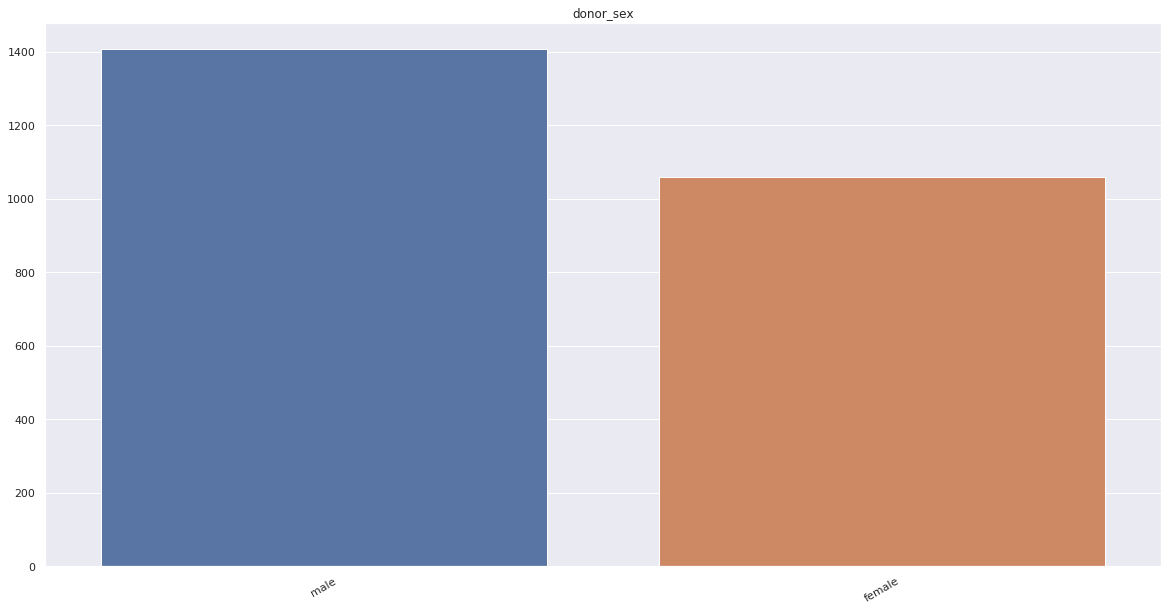

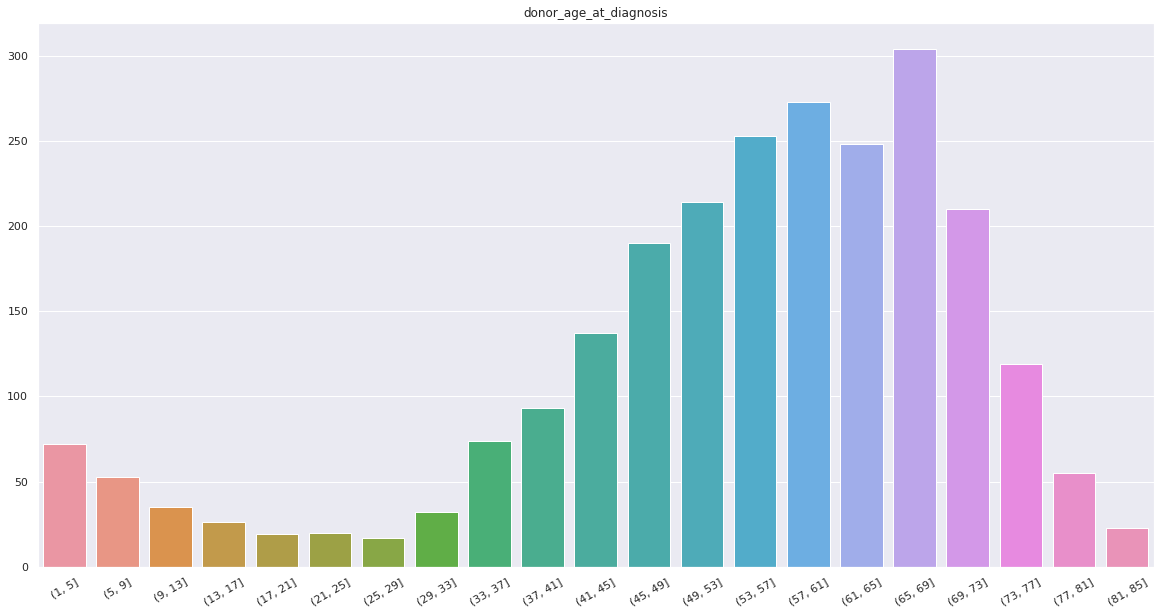

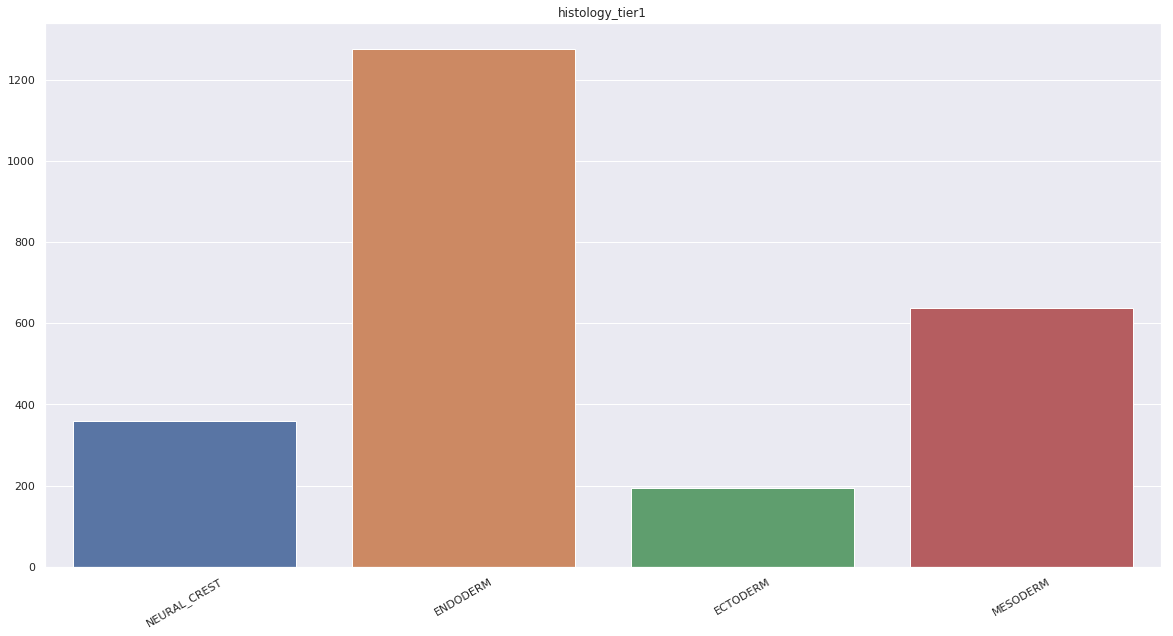

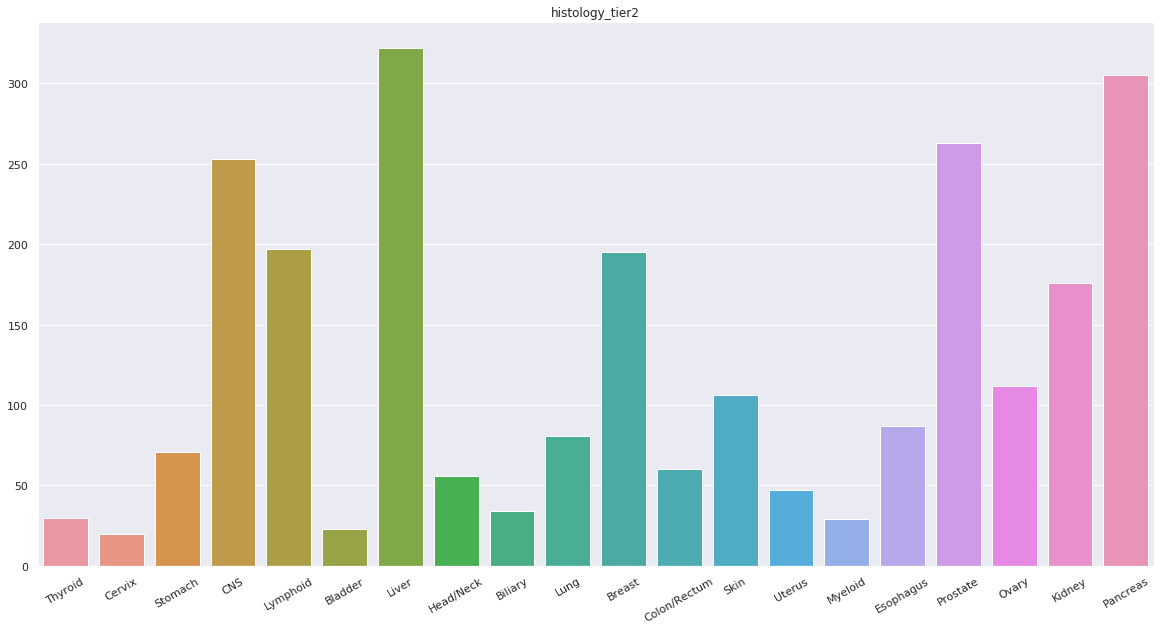

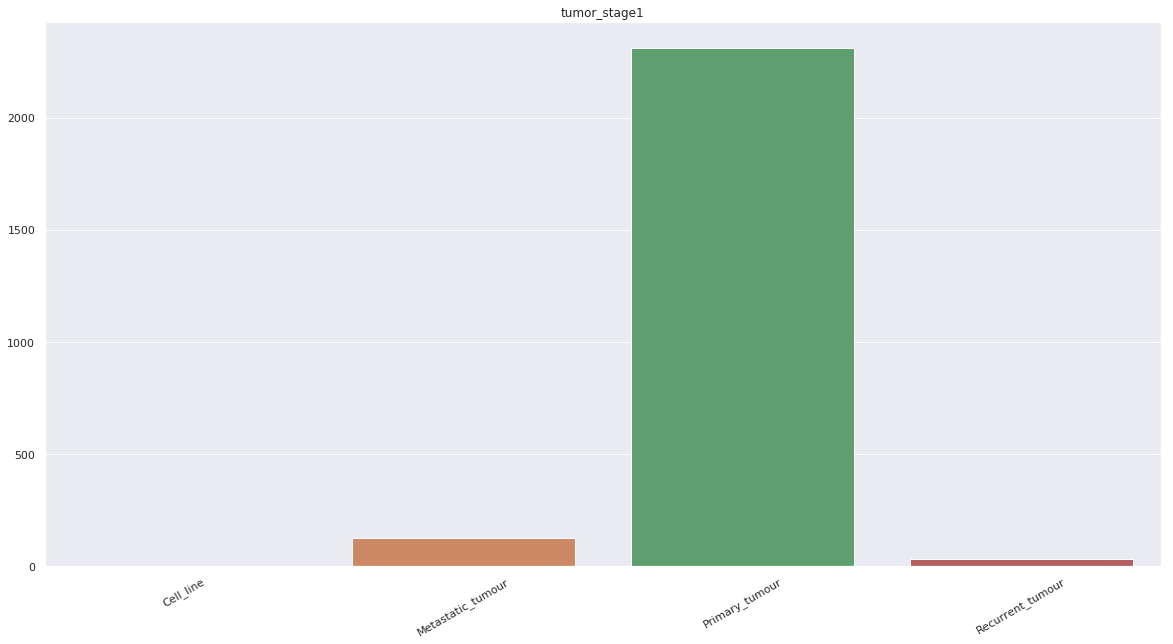

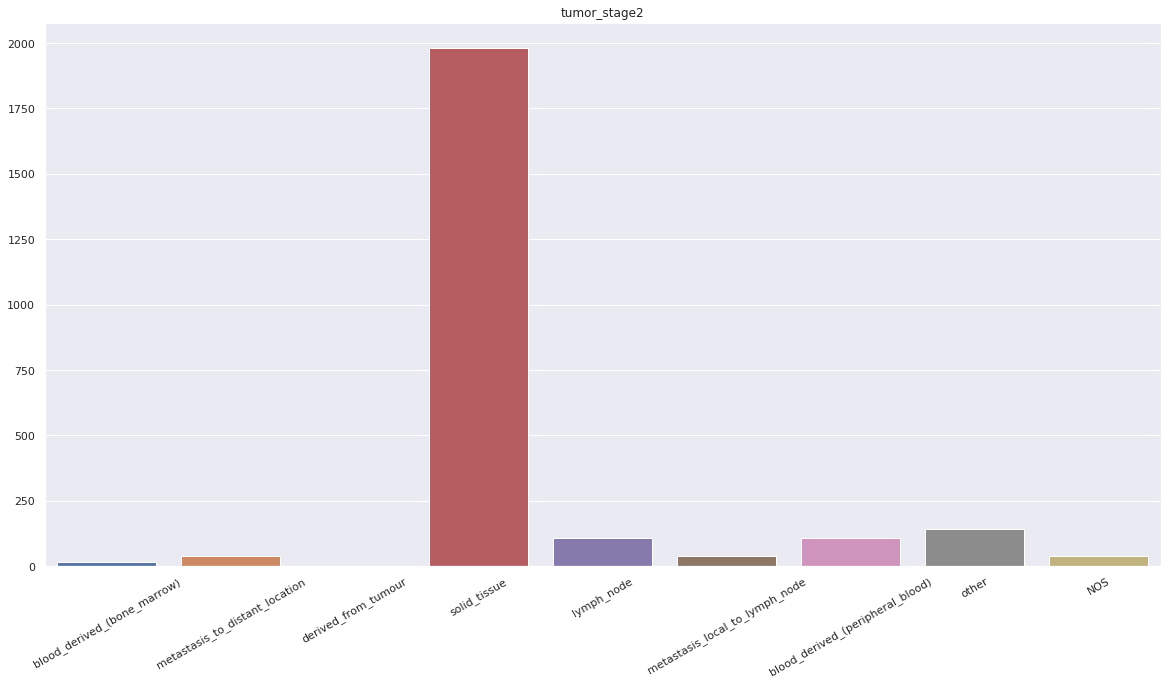

In [8]:
describe(metadata)

### Donor age and nans

In [40]:
def study_donor_age_vs_histology(df):
    """
    This function plots the counting  of values with nans of the donor age features and the age per histology.
    """
    df_nans = df[df.isnull().any(axis=1)]
    plt.figure(figsize=(15, 10))
    values = df_nans['histology_tier1'].values
    d = Counter(values)
    factor = 1.0 #/ sum(d.itervalues())
    D = {k: v * factor for k, v in d.iteritems()}
    sns.barplot(range(len(D)), list(D['ECTODERM']))
    plt.xticks(range(len(D)), list(D.keys()), rotation=30)
    plt.title('Values with nan per histology')
    name = 'age_vs_histology_nans'
    plt.savefig(PLOT_PATH + name)

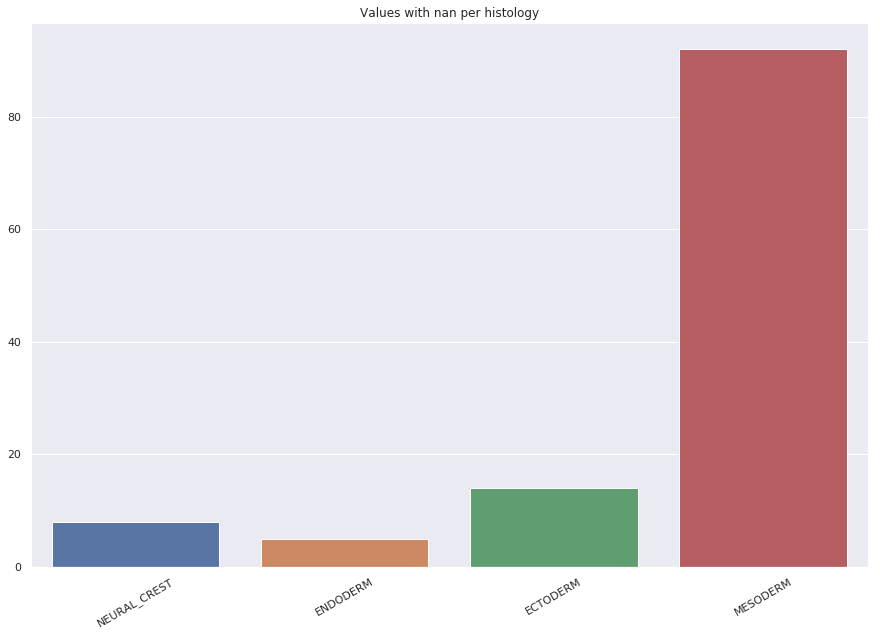

In [41]:
meta_nans = pd.read_csv(METADATAPATH)
study_donor_age_vs_histology(meta_nans)

# Correlation between the features and the histology

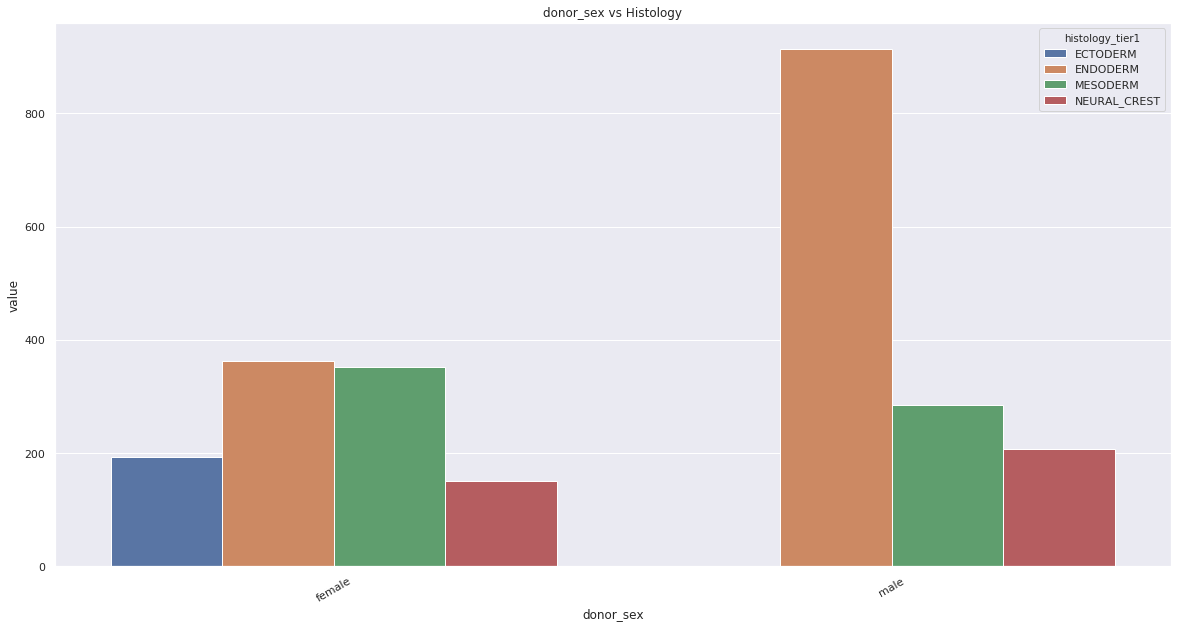

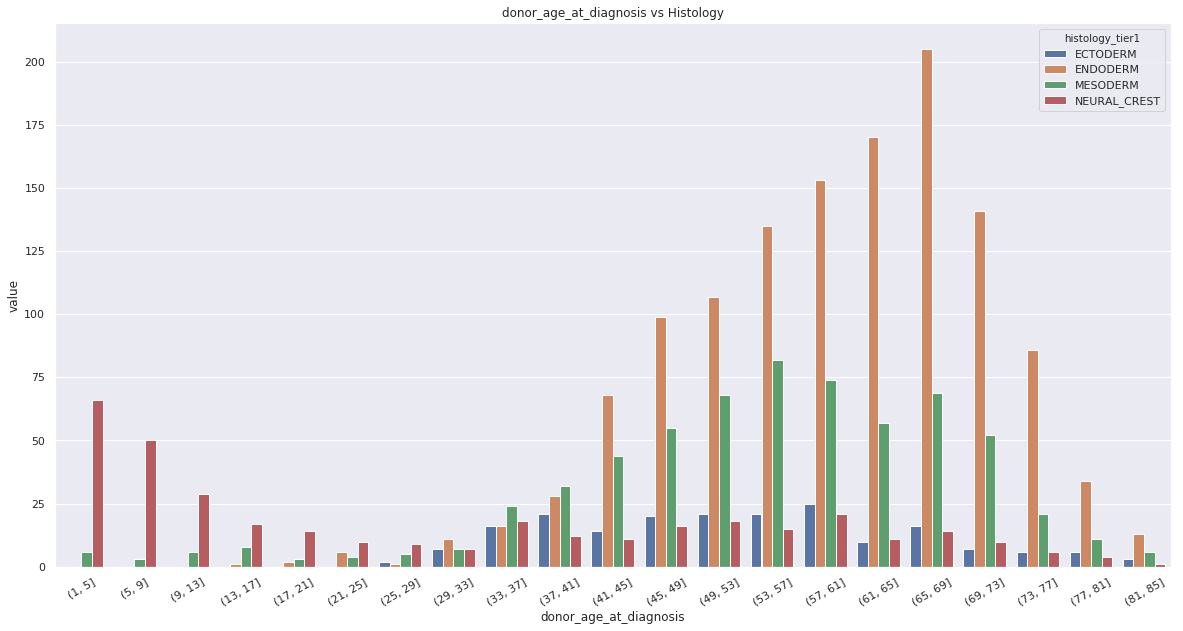

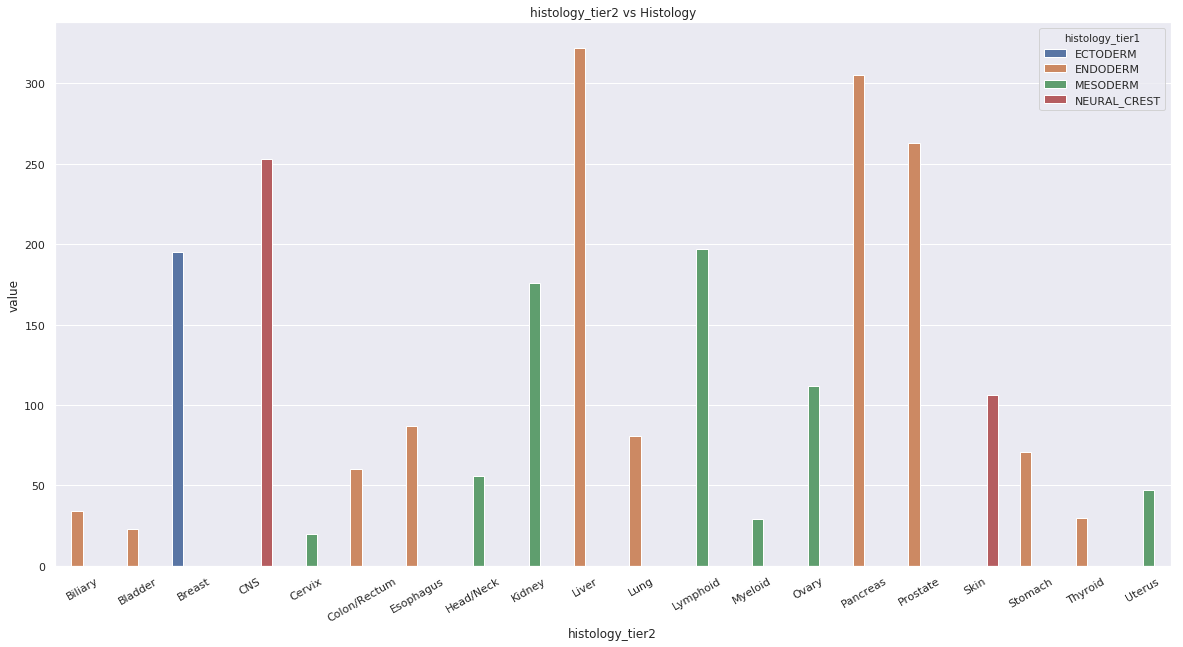

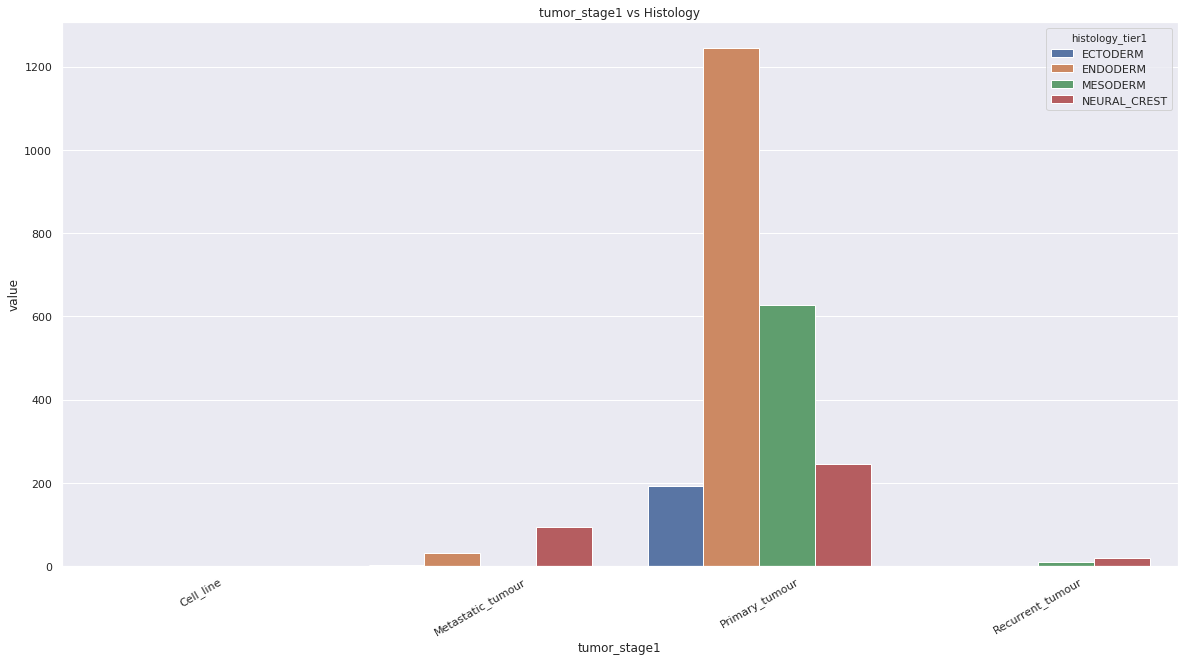

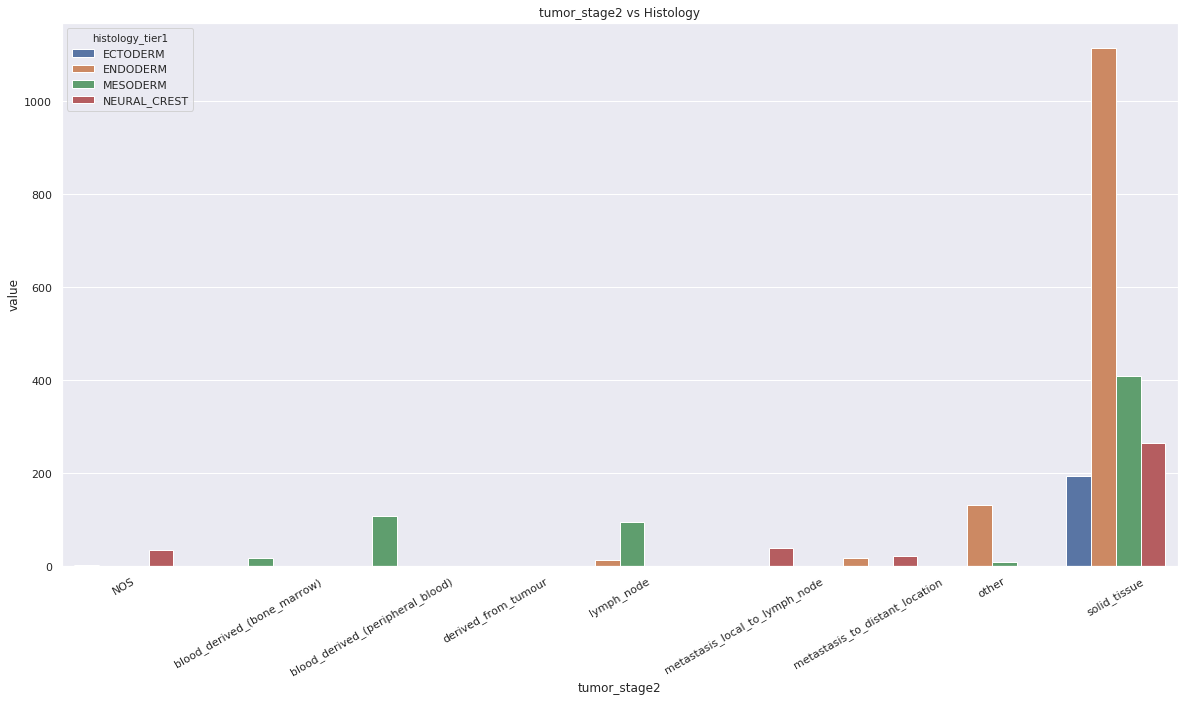

In [32]:
def print_corr_bar_plot(df):
    df.dropna(inplace=True)
    df['donor_age_at_diagnosis'] = df['donor_age_at_diagnosis'].astype(int)
    for col in df.columns:
        if col == 'sampleID':
            continue
        if col == 'histology_tier1':
            continue
        if col == 'donor_age_at_diagnosis':
            lower, higher = df['donor_age_at_diagnosis'].min(), df['donor_age_at_diagnosis'].max()
            n_bins = 20
            edges = range(lower, higher, (higher - lower) / n_bins)  # the number of edges is 8
            lbs = ['(%d, %d]' % (edges[i], edges[i + 1]) for i in range(len(edges) - 2)]
            values = pd.cut(df.donor_age_at_diagnosis, bins=n_bins + 1, labels=lbs, include_lowest=True)
        else:
            values = df[col]
        cross_tab = pd.crosstab(values, df.histology_tier1)
        # now stack and reset
        stacked = cross_tab.stack().reset_index().rename(columns={0: 'value'})

        # plot grouped bar chart
        plt.figure(figsize=(20, 10))
        sns.barplot(x=stacked[col], y=stacked.value, hue=stacked.histology_tier1)
        plt.xticks(rotation=30)
        plt.title(col + ' vs Histology')
        plt.savefig(PLOT_PATH +col + '_vs_histology.png')
        
print_corr_bar_plot(metadata)

# Patient files 

### Traslocations

In [5]:
def plot_heatmap_traslocations(traslocation_df, name):
    """
    This functions generates a heatmap of the traslocations.
    Input: A pandas dataframe with the patients as samples and the number of traslocations as feature. 
    """
    plt.figure(figsize=(15, 15))

    chromosomes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                   '19', '20', '21', '22', 'X', 'Y']

    traslocation_df = traslocation_df.reindex(index=natsorted(traslocation_df.index))
    traslocation_df = traslocation_df[chromosomes]
    traslocation_df = traslocation_df.astype(int)
    traslocation_df = pd.DataFrame(data=np.maximum(traslocation_df.values, traslocation_df.values.transpose()),
                                columns=chromosomes, index=chromosomes, )

    g = sns.heatmap(traslocation_df, annot=True, linewidths=.5, cbar=False, fmt='g')
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    plt.title('Traslocations per chromosome of ' + name)
    plt.savefig(PLOT_PATH + 'traslocations_' + name + '.png')

In [68]:
def plot_type_of_breaks_per_chromosome(cross_df, type_name):
    """
    This function plots a comparative barplot of the number of breaks that have each histology. 
    """
    plt.figure(figsize=(20, 10))
    total =cross_tabs['all'][type_name]
    plt.bar(cross_df['ECTODERM'].index, np.divide(cross_df['ECTODERM'][type_name], total), label='ECTODERM')
    plt.bar(cross_df['ENDODERM'].index, np.divide(cross_df['ENDODERM'][type_name], total),
            bottom=np.divide(cross_df['ECTODERM'][type_name], total), label='ENDODERM')
    plt.bar(cross_df['NEURAL_CREST'].index, np.divide(cross_df['NEURAL_CREST'][type_name], total),
            bottom=np.divide(cross_df['ECTODERM'][type_name], total) + np.divide(cross_df['ENDODERM'][type_name], total),
            label='NEURAL_CREST')
    plt.bar(cross_df['MESODERM'].index, np.divide(cross_df['MESODERM'][type_name], total),
            bottom=np.divide(cross_df['ECTODERM'][type_name], total) + np.divide(cross_df['ENDODERM'][type_name], total) + np.divide(
                cross_df['NEURAL_CREST'][type_name], total), label='MESODERM')

    plt.title(type_name + ' per chromosome per histology')
    plt.legend()
    plt.savefig(PLOT_PATH + type_name +'_per_histology.png')


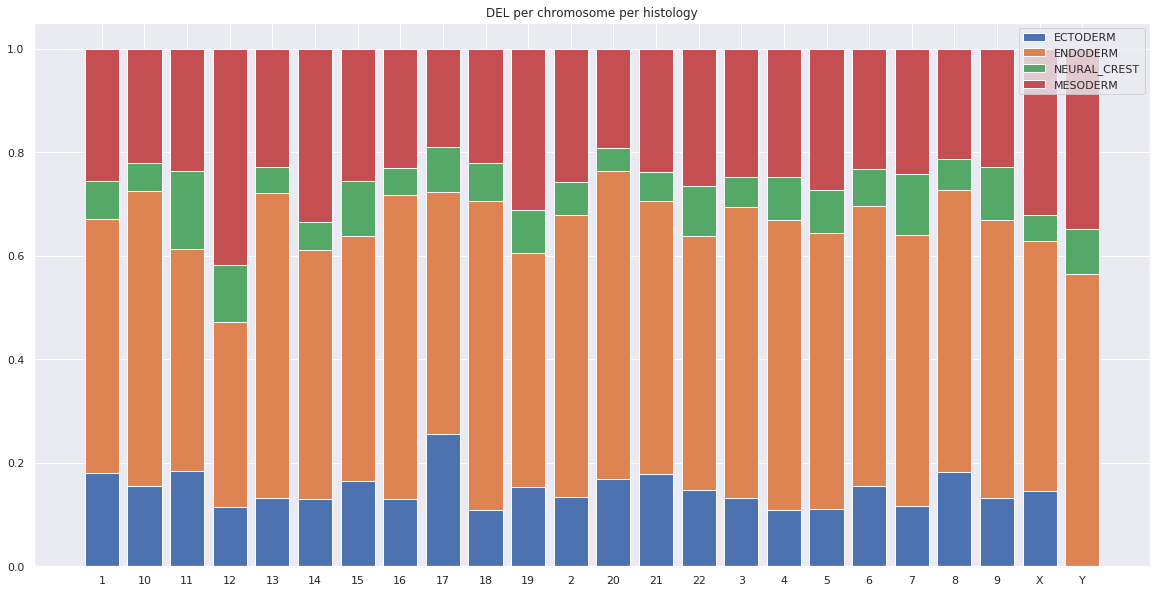

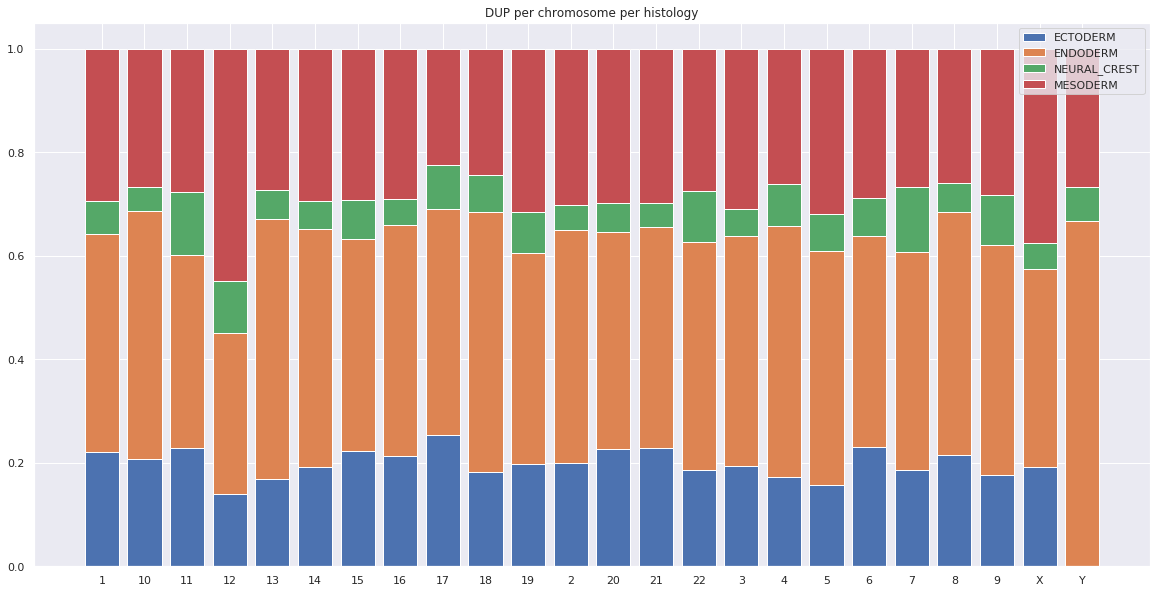

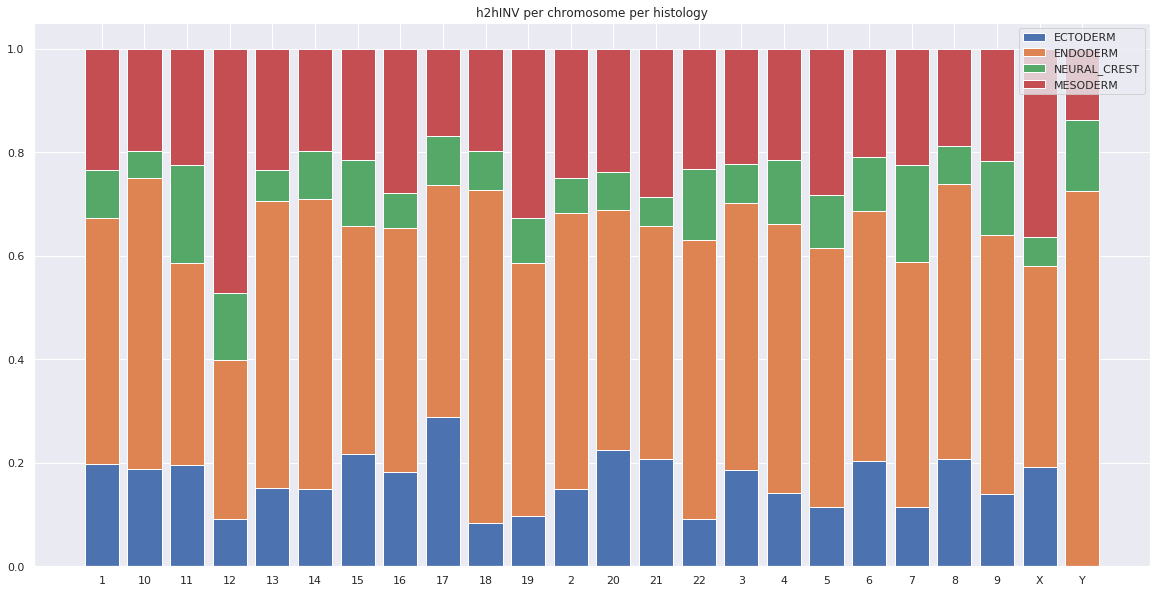

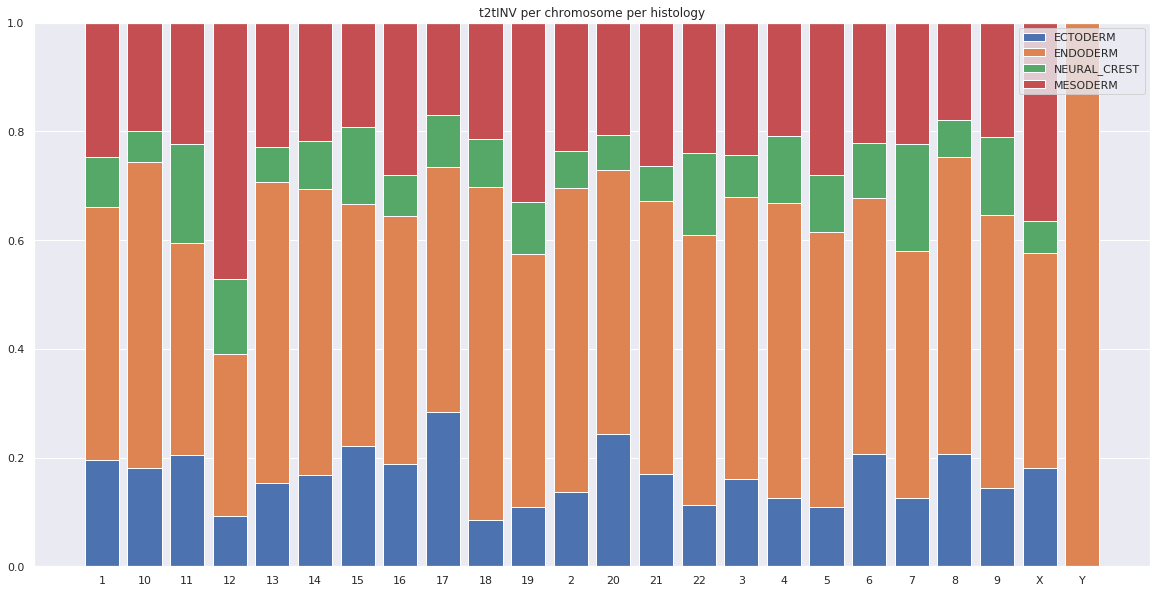

In [70]:
for cls in svclass:
    if cls != 'TRA':
        plot_type_of_breaks_per_chromosome(cross_tabs, cls)

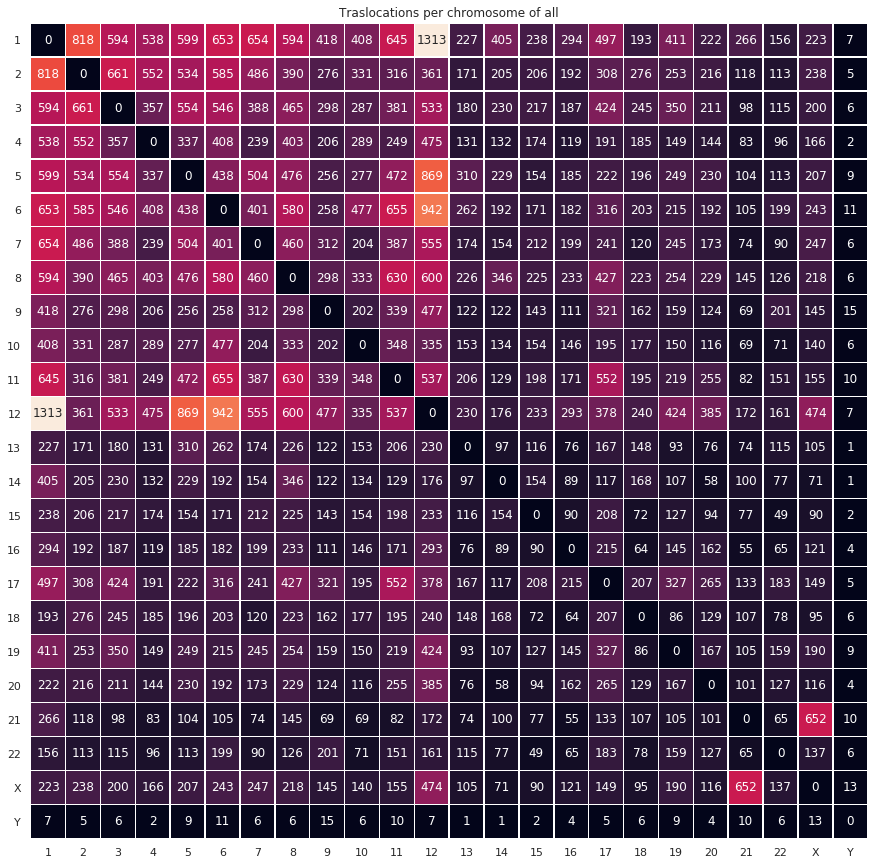

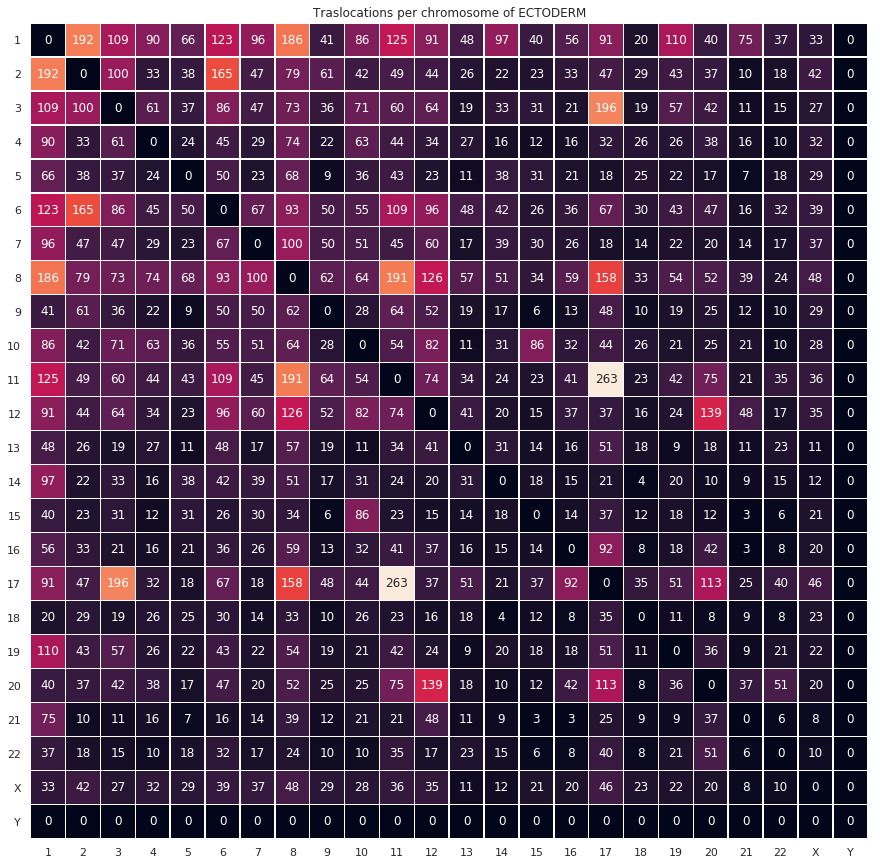

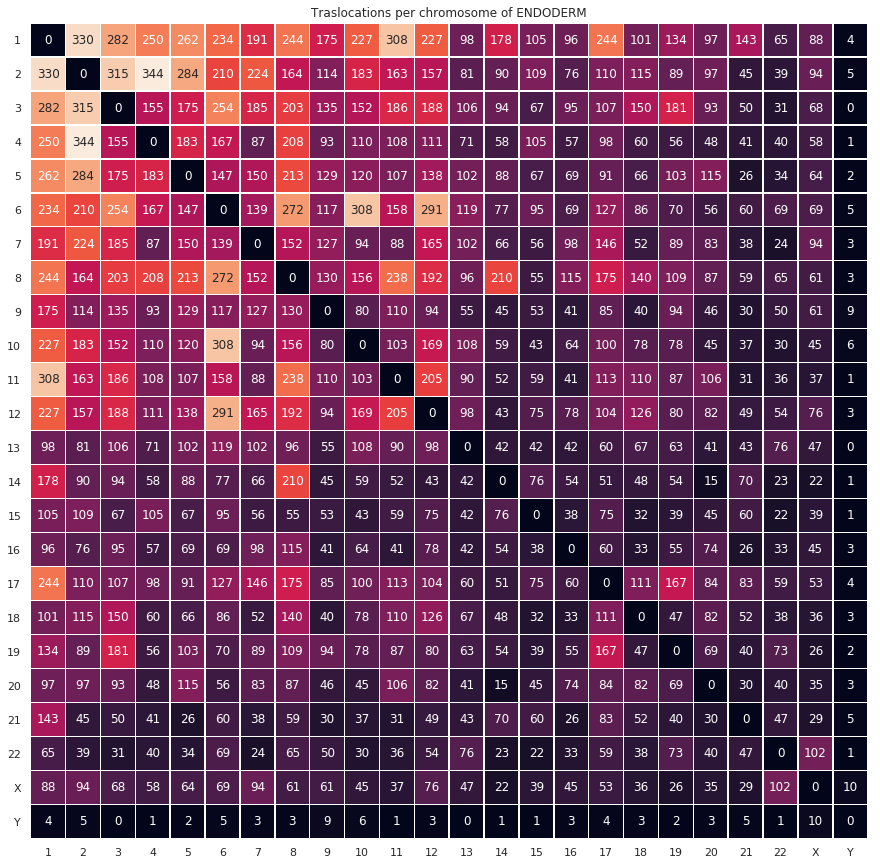

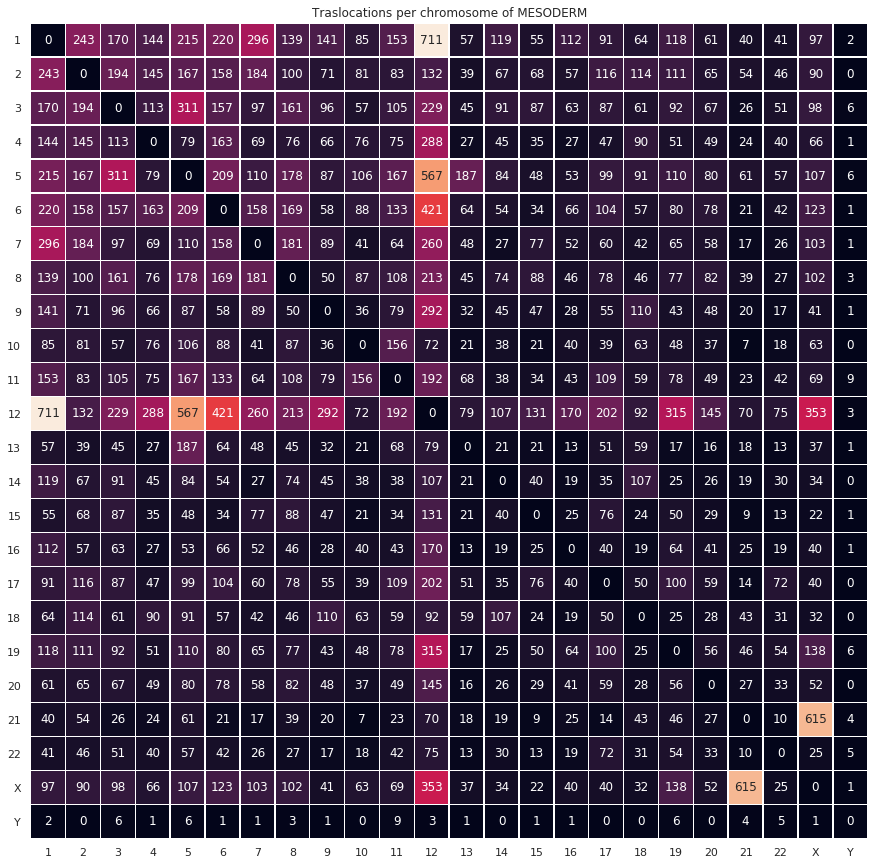

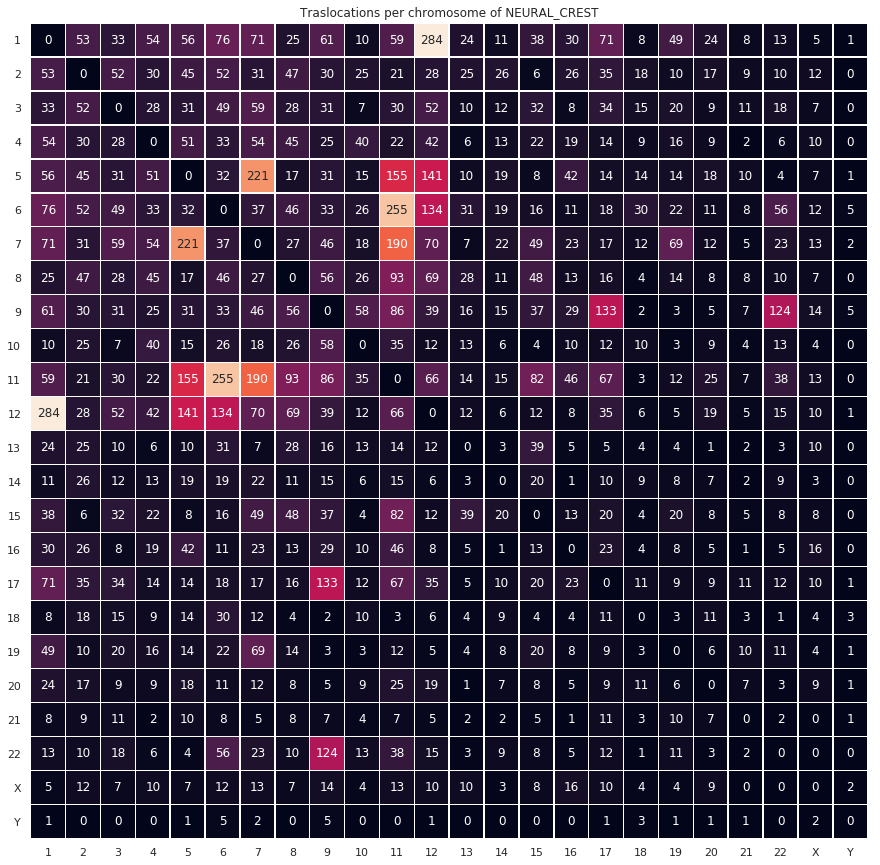

In [30]:
def traslocations_frequency_per_chromosome():
    """
    This function generates crosstabs to compare the frecuency of the traslocations and other kinds of breaks
    in the different chromosomes. 
    """
    
    NUMBER_OF_SAMPLES = -1
    # Directory containing the files
    data_path = DATAPATH + '/raw_original_data/allfiles/'
    
    meta = pd.read_csv(METADATAPATH)
    meta = meta.set_index('sampleID')
    
    all_patients = os.listdir(data_path)[:NUMBER_OF_SAMPLES]
    all_patients = [p.replace('.vcf.tsv', '') for p in all_patients]
    # Take only the patients that have metadata. 
    all_patients = [p for p in all_patients if p in list(meta.index)]
        
    cross_tabs = {}
    
    cross_tabs_traslocations = {}
    
    # I initialize all the crosstabs
    for histology in histologies: 
        cross_tabs[histology] = pd.DataFrame(columns=['DEL', 'DUP', 'TRA', 'h2hINV', 't2tINV'],
                          index=chromosomes)
        cross_tabs_traslocations[histology] = pd.DataFrame(0, columns=chromosomes, index=chromosomes)
        # to avoid formating issues
        cross_tabs[histology].index = cross_tabs[histology].index.map(str)
        cross_tabs_traslocations[histology].index = cross_tabs_traslocations[histology].index.map(str)
        # To obtain the chromosomes ordered
        cross_tabs[histology] = cross_tabs[histology].reindex(index=natsorted(cross_tabs[histology].index))
    
    for patient in all_patients:
        patient_path = data_path + patient + '.vcf.tsv'
        # load patient breaks
        patient_breaks = pd.read_csv(patient_path, sep='\t', index_col=None)
        # load the chromosomes as strings
        patient_breaks['chrom2'] = patient_breaks['chrom2'].map(str)
        # generate a crosstab of the svclass with the chromosomes
        ct = pd.crosstab(patient_breaks['chrom2'], patient_breaks['svclass'])
        ct.index = ct.index.map(str)

        patient_histology = meta.loc[patient, 'histology_tier1']

        cross_tabs['all'] = cross_tabs['all'].add(ct, fill_value=0)
        cross_tabs[patient_histology] = cross_tabs[patient_histology].add(ct,fill_value=0)
        
        # The TRA classes have different chromosome1 and chromosome2, I want to make a heatmap of the changes.
        only_TRA = patient_breaks.loc[patient_breaks['svclass'] == 'TRA']
        ct_tra = pd.crosstab(only_TRA['#chrom1'], only_TRA['chrom2'])
        ct_tra.index = ct_tra.index.map(str)
        
        cross_tabs_traslocations['all'] = cross_tabs_traslocations['all'].add(ct_tra, fill_value=0)
        cross_tabs_traslocations[patient_histology] = cross_tabs_traslocations[patient_histology].add(ct_tra, fill_value=0)
        
        for hist in histologies:
            cross_tabs[hist] = cross_tabs[hist].fillna(0)
    return cross_tabs, cross_tabs_traslocations
        

cross_tabs, cross_tabs_traslocations = traslocations_frequency_per_chromosome()

for hist in histologies:
    plot_heatmap_traslocations(cross_tabs_traslocations[hist],hist)

In [25]:
cross_tabs

{'ECTODERM':      DEL   DUP   TRA h2hINV t2tINV
 1   1175  1405     0    581    575
 10   512   610    86    264    246
 11   790   955   179    491    498
 12   590   685   247    321    309
 13   321   306   134    142    150
 14   305   394   203    118    122
 15   263   388   196    125    148
 16   317   421   211    125    122
 17   789   823   636    578    565
 18   217   324   162    101     91
 19   358   453   324    149    161
 2    837  1074   550    359    323
 20   390   416   555    187    202
 21   206   221   281     99     86
 22   143   210   295     41     50
 3    865   987   848    440    373
 4    509   573   544    265    214
 5    556   632   475    247    231
 6    774  1003  1116    475    475
 7    549   737   682    234    250
 8    953   940  1615    546    589
 9    408   444   654    170    182
 X    520   456   608    267    258
 Y    NaN   NaN   NaN    NaN    NaN,
 'ENDODERM':      DEL   DUP   TRA h2hINV t2tINV
 1   3196  2669     0   1408   1362
 10